# Game Situation Analysis

This notebook focuses on analysing NHL shot types across different game scenarios to answer questions such as "Do NHL players use different shots when they are losing the game?". To begin this analysis we first have to import the necessary packages and load the cleaned data base.

In [196]:
# Importing all necessary packages
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Wedge
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

DATA_PATH = Path("../data/")
PICKLE_PATH = Path("../pickled_data/")

In [197]:
# Loading the necessary pickled file after cleaning
game_plays = pd.read_pickle(PICKLE_PATH / 'game_plays')

In [198]:
# Ensure dateTime is in datetime format
game_plays['dateTime'] = pd.to_datetime(game_plays['dateTime'])

# Filter rows where the year is 2018
game_plays2018 = game_plays[(game_plays['dateTime'].dt.year == 2018) & (game_plays['dateTime'].dt.month == 4) & (game_plays['team_id_for'] == 20)]


To analyze where the players were when the shot occured we created a function that draws a hockey rink with regulation NHL dimensions. This example visualizes every shot type and goal for Calgary Flames players during the month of April 2018. 

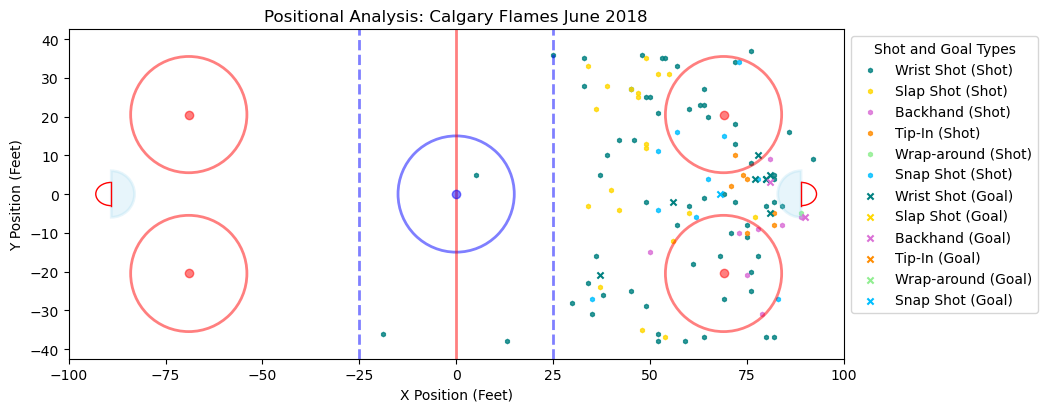

In [199]:
# Calgary Flames Shots and Goals from April 2018 (3 games)

# Function for drawing key rink features. Dimensions from https://www.hockeymanitoba.ca/wp-content/uploads/2013/03/Rink-Marking-Diagrams.pdf
def draw_rink(ax):
    '''
    Displays a hockey rink with NHL dimensions at current axes
    Parameter ax: Current axes
    Returns nothing
    '''

    # Draw the center ice line
    ax.axvline(0, color='red', linestyle='-', linewidth=2, alpha=0.5)
    
    # Draw the blue lines at +/- 25 feet from center ice
    ax.axvline(-25, color='blue', linestyle='--', linewidth=2, alpha=0.5)
    ax.axvline(25, color='blue', linestyle='--', linewidth=2, alpha=0.5)

    # Draw blue faceoff circle at center ice (15 ft radius) with blue dot at the center
    center_circle = plt.Circle((0, 0), 15, edgecolor='blue', facecolor='none', alpha = 0.5, lw=2)
    ax.add_patch(center_circle)
    ax.plot(0, 0, marker='o', color='blue', alpha = 0.5, markersize=6)  
    
    # Draw the 4 red faceoff circles with red dots at center (31 feet from end boards and 20.5 feet from side boards)
    faceoff_positions = [(69, 20.5), (-69, 20.5), (69, -20.5), (-69, -20.5)]
    for x, y in faceoff_positions:
        faceoff_circle = plt.Circle((x, y), 15, edgecolor='red', facecolor='none', alpha = 0.5, lw=2)
        ax.add_patch(faceoff_circle)
        ax.plot(x, y, marker='o', color='red', alpha = 0.5, markersize=6)  
    
    # Draw goal lines for net (6 ft)
    ax.plot([-89, -89], [-3, 3], color='red', lw=1)  # Left goal line
    ax.plot([89, 89], [-3, 3], color='red', lw=1)    # Right goal line

    # Draw back of goals as arcs (6 ft wide and 4 ft deep)
    left_goal= Arc((-89, 0), width=6, height=8, angle=90, theta1=360, theta2=180, color='red', lw=1)
    right_goal = Arc((89, 0), width=6, height=8, angle=90, theta1=180, theta2=360, color='red', lw=1)

    ax.add_patch(left_goal)
    ax.add_patch(right_goal)

    # Draw the goal creases using Wedges and fill with low opacity (6 ft radius)
    left_goal_crease = Wedge((-89, 0), r=6, theta1=270, theta2=90, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)
    right_goal_crease = Wedge((89, 0), r=6, theta1=90, theta2=270, color='skyblue', alpha=0.2, edgecolor='blue', lw=2)

    ax.add_patch(left_goal_crease)
    ax.add_patch(right_goal_crease)

    # Set the rink bounds (200 ft by 85 ft)
    ax.set_xlim(-100, 100)        
    ax.set_ylim(-42.5, 42.5)

    # Treat x and y units equally so circles are drawn correctly
    ax.set_aspect('equal')

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Get the current axes
ax = plt.gca()  

# Filter shots and goals
shots = game_plays2018[game_plays2018['event'] == 'Shot']
goals = game_plays2018[game_plays2018['event'] == 'Goal']

# Give each shot a distinctive color
shot_colors = {
    'Wrist Shot': 'teal',
    'Slap Shot': 'gold',
    'Backhand': 'orchid',
    'Tip-In': 'darkorange',
    'Wrap-around': 'lightgreen',
    'Snap Shot': 'deepskyblue'
}

# Plot shots based on their type
for shot_type, color in shot_colors.items():
    show_shot = shots[(shots['secondaryType'] == shot_type)]
    ax.scatter(show_shot['st_x'], show_shot['st_y'], color=color, marker='h', s=10, label=f'{shot_type} (Shot)', alpha=0.8)

# Plot goals based on their shot type
for shot_type, color in shot_colors.items():
    show_goal = goals[goals['secondaryType'] == shot_type]
    ax.scatter(show_goal['st_x'], show_goal['st_y'], color=color, marker='x', s=20, label=f'{shot_type} (Goal)', alpha=1)

# Draw the rink at current axes using the custom function
draw_rink(ax)

# Labels and legend
plt.title("Positional Analysis: Calgary Flames June 2018")
plt.xlabel("X Position (Feet)")
plt.ylabel("Y Position (Feet)")
plt.legend(title='Shot and Goal Types', loc='upper right', bbox_to_anchor=(1.26, 1))
plt.show()

To analyze what types of shots players use and which are the most succesfull when a team is winning vs. when a team is losing, we need to extract some data from the game_plays dataframe. First we add 'team_winning' and 'team_losing' columns to the dataframe and then we can filter all the different shots and shot counts.

In [200]:
# Visualizing shot types and goals when a team is winning and losing

# Create a column for when a team was winning
game_plays['team_winning'] = ((game_plays['team_id_for'] == game_plays['goals_home']) & (game_plays['goals_home'] > game_plays['goals_away'])) | \
                             ((game_plays['team_id_for'] == game_plays['goals_away']) & (game_plays['goals_away'] > game_plays['goals_home']))

# Create a column for when a team is losing
game_plays['team_losing'] = ((game_plays['team_id_for'] == game_plays['goals_home']) & (game_plays['goals_home'] < game_plays['goals_away'])) | \
                             ((game_plays['team_id_for'] == game_plays['goals_away']) & (game_plays['goals_away'] < game_plays['goals_home']))

# Filter shots and goals when losing
losing_shots = game_plays[(game_plays['team_losing']) & (game_plays['event'] == 'Shot')]
losing_goals = game_plays[(game_plays['team_losing']) & (game_plays['event'] == 'Goal')]

# Filter shots and goals when winning
winning_shots = game_plays[(game_plays['team_winning']) & (game_plays['event'] == 'Shot')]
winning_goals = game_plays[(game_plays['team_winning']) & (game_plays['event'] == 'Goal')]

# Count occurrences by shot type for both winning and losing scenarios
shot_types = sorted(set(losing_shots['secondaryType']).union(set(winning_shots['secondaryType'])))
losing_shot_counts = [losing_shots['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]
losing_goal_counts = [losing_goals['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]
winning_shot_counts = [winning_shots['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]
winning_goal_counts = [winning_goals['secondaryType'].value_counts().get(shot_type, 0) for shot_type in shot_types]


# Calculate total shots and goals for percentage calculation
total_losing_shots = sum(losing_shot_counts)
total_losing_goals = sum(losing_goal_counts)
total_winning_shots = sum(winning_shot_counts)
total_winning_goals = sum(winning_goal_counts)


First we will look strictly at shots that were saved for both winning teams and losing teams using a double bar graph and annotating the percentage for each shot type. We will look at the counts for every shot in the game_plays dataframe.

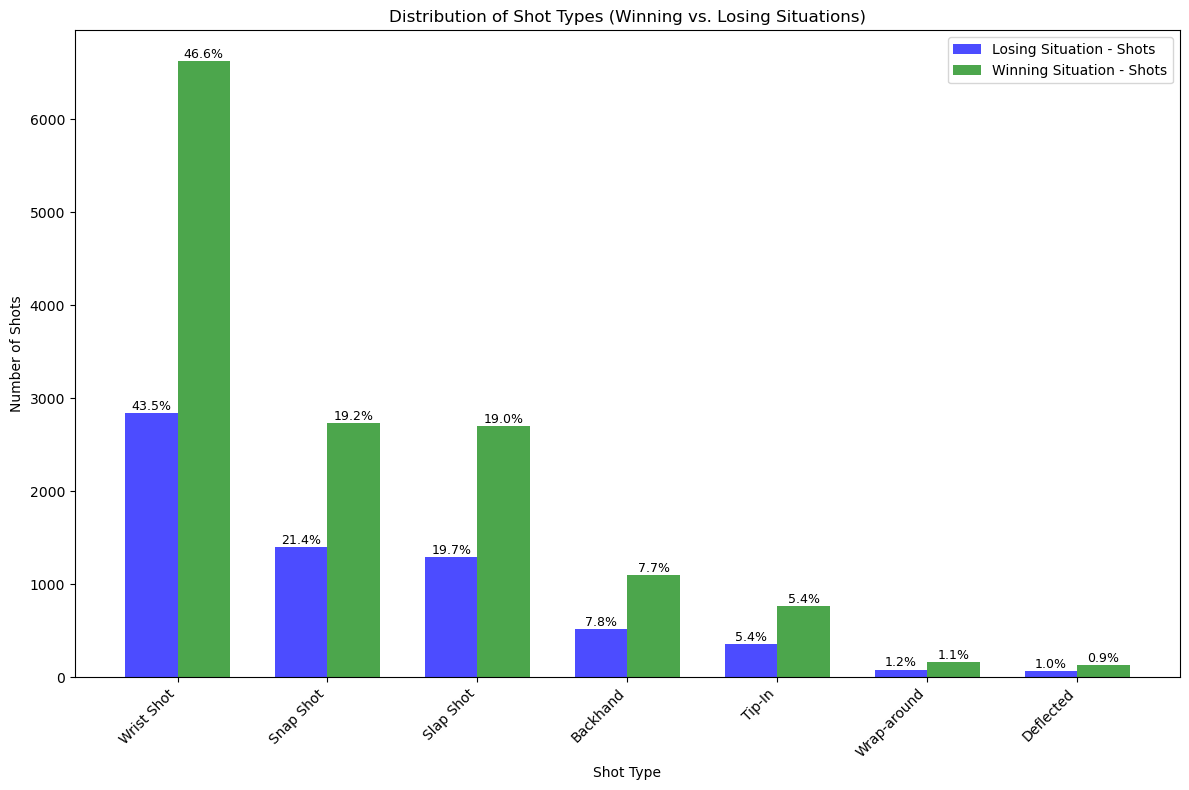

In [201]:
import numpy as np
import matplotlib.pyplot as plt

# Sort shot types and counts in descending order
sorted_indices = np.argsort(losing_shot_counts)[::-1]
shot_types = [shot_types[i] for i in sorted_indices]
losing_shot_counts = [losing_shot_counts[i] for i in sorted_indices]
winning_shot_counts = [winning_shot_counts[i] for i in sorted_indices]

# Recalculate total shots after sorting
total_losing_shots = sum(losing_shot_counts)
total_winning_shots = sum(winning_shot_counts)

# Calculate percentages
losing_shot_percentages = [(count / total_losing_shots) * 100 if total_losing_shots > 0 else 0 for count in losing_shot_counts]
winning_shot_percentages = [(count / total_winning_shots) * 100 if total_winning_shots > 0 else 0 for count in winning_shot_counts]

# Create bar positions
x = np.arange(len(shot_types))
bar_width = 0.35  

# Set size of plot
plt.figure(figsize=(12, 8))

# Plot bars for losing and winning shots
losing_bars = plt.bar(x - bar_width/2, losing_shot_counts, bar_width, color='blue', label='Losing Situation - Shots', alpha=0.7)
winning_bars = plt.bar(x + bar_width/2, winning_shot_counts, bar_width, color='green', label='Winning Situation - Shots', alpha=0.7)

# Add percentage annotations
for i in range(len(shot_types)):
    # Losing shot percentage
    if losing_shot_counts[i] > 0:
        plt.text(x[i] - bar_width/2, losing_shot_counts[i] + 1, f"{losing_shot_percentages[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')
    # Winning shot percentage
    if winning_shot_counts[i] > 0:
        plt.text(x[i] + bar_width/2, winning_shot_counts[i] + 1, f"{winning_shot_percentages[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')

# Add labels and title
plt.xlabel('Shot Type')
plt.ylabel('Number of Shots')
plt.title('Distribution of Shot Types (Winning vs. Losing Situations)')
plt.xticks(x, shot_types, rotation=45, ha='right')
plt.legend()
plt.tight_layout()  
plt.show()




From this visualization, we can see that players choose similar shots regardless of whether they are winning or losing. The greatest disparities are between wrist shot and snap shots. Winning teams seem to choose wrist shots more often, suggesting they are utilizing the "Pucks to the Net" strategy. Winning teams generally finish the game with more shots on net. Additionally, once they have the lead, a high shot volume will keep pressure on the defending team, as well as keeping the puck in their zone where they have no chance of scoring. Losing teams tend to utilize snap shots more often than winning teams. This may be because when a team is struggling they feel the need to set up a more dangerous scoring chance to ensure a goal, or catch a hot goalie off guard with a speedy shot.

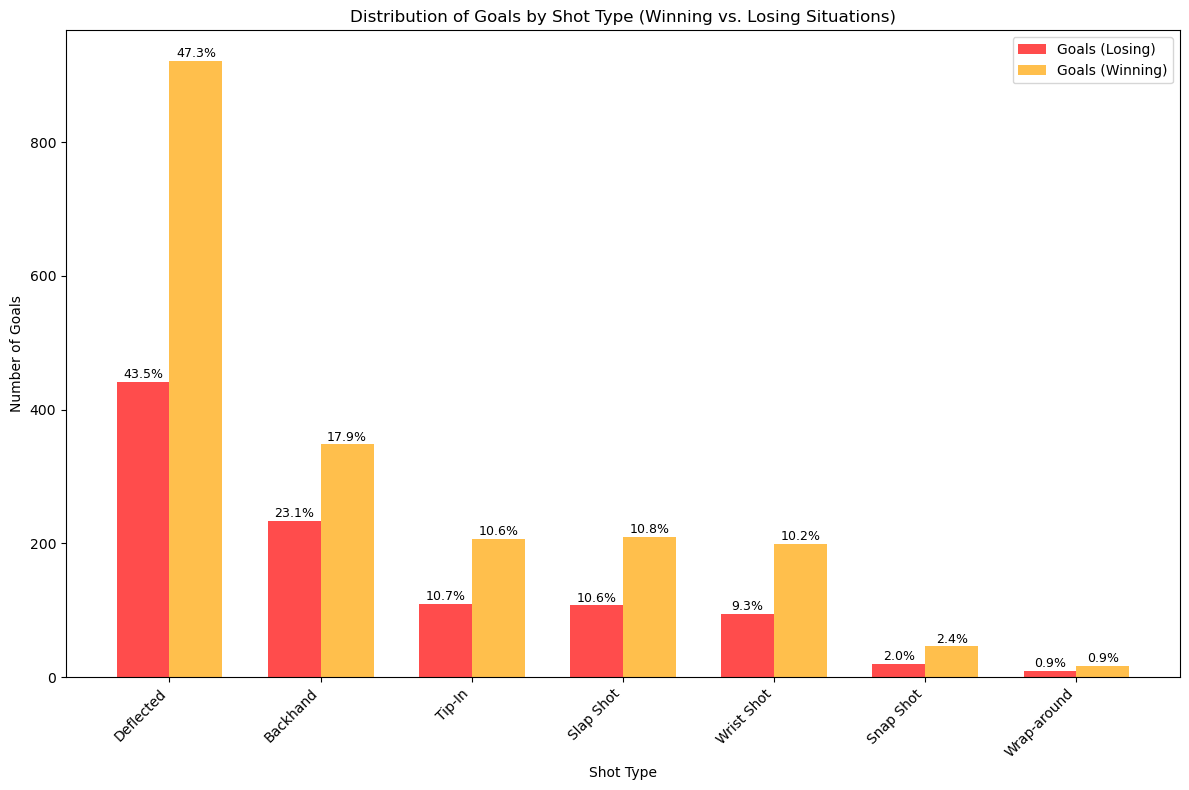

In [202]:

# Sort shot types and counts in descending order
sorted_indices = np.argsort(losing_goal_counts)[::-1]
shot_types = [shot_types[i] for i in sorted_indices]
losing_goal_counts = [losing_goal_counts[i] for i in sorted_indices]
winning_goal_counts = [winning_goal_counts[i] for i in sorted_indices]

# Recalculate total goals after sorting
total_losing_goals = sum(losing_goal_counts)
total_winning_goals = sum(winning_goal_counts)

# Calculate percentages
losing_goal_percentages = [(count / total_losing_goals) * 100 if total_losing_goals > 0 else 0 for count in losing_goal_counts]
winning_goal_percentages = [(count / total_winning_goals) * 100 if total_winning_goals > 0 else 0 for count in winning_goal_counts]

# Create bar positions
x = np.arange(len(shot_types))
bar_width = 0.35  

# Set size of plot
plt.figure(figsize=(12, 8))

# Plot bars for losing and winning goals
losing_goal_bars = plt.bar(x - bar_width/2, losing_goal_counts, bar_width, color='red', label='Goals (Losing)', alpha=0.7)
winning_goal_bars = plt.bar(x + bar_width/2, winning_goal_counts, bar_width, color='orange', label='Goals (Winning)', alpha=0.7)

# Add percentage annotations
for i in range(len(shot_types)):
    # Annotations for losing goals
    if losing_goal_counts[i] > 0:
        plt.text(x[i] - bar_width/2, losing_goal_counts[i] + 1, f"{losing_goal_percentages[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')
    # Annotations for winning goals
    if winning_goal_counts[i] > 0:
        plt.text(x[i] + bar_width/2, winning_goal_counts[i] + 1, f"{winning_goal_percentages[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')

# Add labels and title
plt.xlabel('Shot Type')
plt.ylabel('Number of Goals')
plt.title('Distribution of Goals by Shot Type (Winning vs. Losing Situations)')
plt.xticks(x, shot_types, rotation=45, ha='right')
plt.legend()
plt.tight_layout()  
plt.show()




From this visualization, we can see that the high volume of wrist shots from winning teams accounts for almost half their goals. This shows how effective the "Pucks to the Net" strategy is not only for killing time, but also increasing the goal differential. While losing teams do have some success with the snap shot, they don't have enough shot volume to win the game.

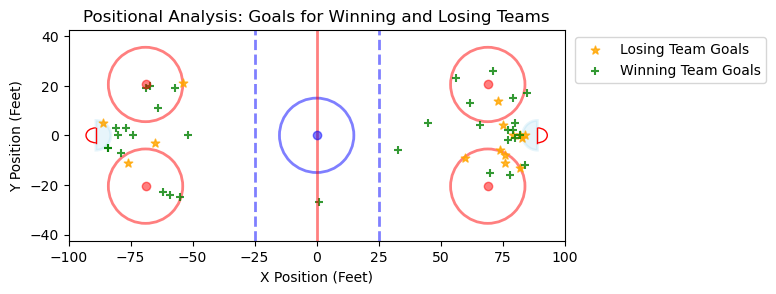

In [203]:
# Winning vs. Losing Goals October 2018
ax = plt.gca()

# Draw the rink at current axes using the custom function
draw_rink(ax)   

# Plot winning and losing team shots and goals (filtered using boolean indexing)
ax.scatter(losing_goals[(losing_goals['dateTime'].dt.year == 2018) & (losing_goals['dateTime'].dt.month == 10)]['x'], 
           losing_goals[(losing_goals['dateTime'].dt.year == 2018) & (losing_goals['dateTime'].dt.month == 10)]['y'], 
           color='orange', marker='*', s=40, label='Losing Team Goals', alpha=0.8)

ax.scatter(winning_goals[(winning_goals['dateTime'].dt.year == 2018) & (winning_goals['dateTime'].dt.month == 10)]['x'], 
           winning_goals[(winning_goals['dateTime'].dt.year == 2018) & (winning_goals['dateTime'].dt.month == 10)]['y'], 
           color='green', marker='+', s=40, label='Winning Team Goals', alpha=0.8)

# Labels and legend
plt.title("Positional Analysis: Goals for Winning and Losing Teams")
plt.xlabel("X Position (Feet)")
plt.ylabel("Y Position (Feet)")
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.42, 1))
plt.show()

Here we can see the exact location where the player was shooting from when a goal was scored. This visualization filters shots and goals from October 2018 (the start of the season), in order to not overpopulate the rink with markers. This visualization is inline with our hypothesis that winning teams are getting pucks to the net no matter where they are on the ice. They also have a lot of success just outside the crease, where they can block the goalies vision and get a tip on the puck right in front of the net where the goalie has no chance to react. This strategy makes it nearly impossible for even the best goaltenders to stop the puck. In contrast, the losing teams scores more goals in the slot area or just off to the side of the net. This provides further evidence that losing teams are trying to get in position to set up that perfect snap shot or one timer.

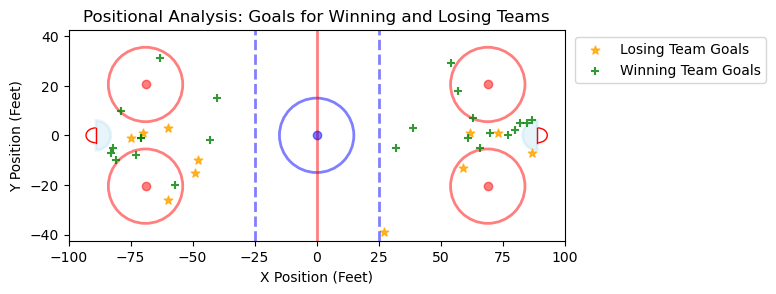

In [204]:
# Winning vs. Losing Goals April 2018
ax = plt.gca()

# Draw the rink at current axes using the custom function
draw_rink(ax)   

# Plot winning and losing team goals (filtered using boolean indexing)
ax.scatter(losing_goals[(losing_goals['dateTime'].dt.year == 2018) & (losing_goals['dateTime'].dt.month == 4)]['x'], 
           losing_goals[(losing_goals['dateTime'].dt.year == 2018) & (losing_goals['dateTime'].dt.month == 4)]['y'], 
           color='orange', marker='*', s=40, label='Losing Team Goals', alpha=0.8)

ax.scatter(winning_goals[(winning_goals['dateTime'].dt.year == 2018) & (winning_goals['dateTime'].dt.month == 4)]['x'], 
           winning_goals[(winning_goals['dateTime'].dt.year == 2018) & (winning_goals['dateTime'].dt.month == 4)]['y'], 
           color='green', marker='+', s=40, label='Winning Team Goals', alpha=0.8)

# Labels and legend
plt.title("Positional Analysis: Goals for Winning and Losing Teams")
plt.xlabel("X Position (Feet)")
plt.ylabel("Y Position (Feet)")
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.42, 1))
plt.show()

The purpose of this visualization is to look at goals from winning and losing teams in the April, which is the last month of the season. Interestingly, we see the losing teams take more chances from further away from the net. This may be a result of teams becoming desperate to win in order to make the playoffs, as well as teams that won't the playoffs worrying less about that perfect shot when nothing is on the line. Either way the losing teams still seem to struggle with the important net front presence, that takes away the goalies eyes and creates tip in goals and rebounds.

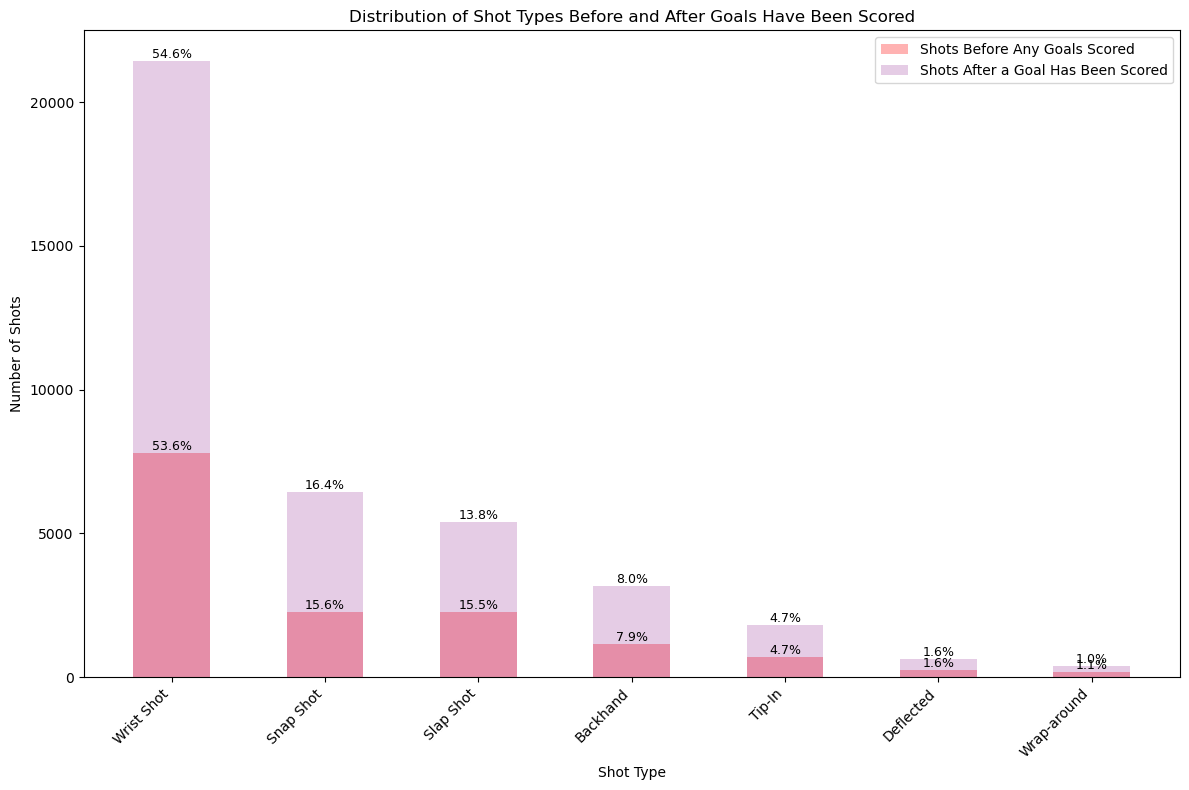

In [205]:
# Filter for shots before any goals have been scored
shots_no_goals_against = game_plays[
    (game_plays['event'] == 'Shot') & 
    (game_plays['goals_home'] == 0) & 
    (game_plays['goals_away'] == 0) & 
    (game_plays['dateTime'].dt.year == 2018)
]

shots_goals_against = game_plays[
    (game_plays['event'] == 'Shot') & 
    (game_plays['goals_home'] != 0) & 
    (game_plays['goals_away'] != 0) & 
    (game_plays['dateTime'].dt.year == 2018) 
]

# Count the number of shots by type
shot_counts_dict = shots_no_goals_against['secondaryType'].value_counts().to_dict()
shot_types = list(shot_counts_dict.keys())
shot_counts = list(shot_counts_dict.values())

shot_counts_against_dict = shots_goals_against['secondaryType'].value_counts().to_dict()
shot_types_against = list(shot_counts_against_dict.keys())
shot_counts_against = list(shot_counts_against_dict.values())

# Sort shot types and counts in descending order
sorted_indices = np.argsort(shot_counts)[::-1]
shot_types = [shot_types[i] for i in sorted_indices]
shot_counts = [shot_counts[i] for i in sorted_indices]

sorted_indices_against = np.argsort(shot_counts_against)[::-1]
shot_types_against = [shot_types_against[i] for i in sorted_indices_against]
shot_counts_against = [shot_counts_against[i] for i in sorted_indices_against]

# Calculate total shots and percentages
total_shots = sum(shot_counts)
shot_percentages = [(count / total_shots) * 100 if total_shots > 0 else 0 for count in shot_counts]

total_shots_against = sum(shot_counts_against)
shot_percentages_against = [(count / total_shots_against) * 100 if total_shots_against > 0 else 0 for count in shot_counts_against]

# Create bar positions
x = np.arange(len(shot_types))
x_against = np.arange(len(shot_types_against))
bar_width = 0.5  

# Set size of plot
plt.figure(figsize=(12, 8))

# Plot bars for shot counts
plt.bar(x, shot_counts, bar_width, color='red', alpha=0.3, label='Shots Before Any Goals Scored')

# Plot bars for shot counts after a goal has been scored
plt.bar(x_against, shot_counts_against, bar_width, color='purple', alpha=0.2, label='Shots After a Goal Has Been Scored')

# Add percentage annotations
for i in range(len(shot_types)):
    if shot_counts[i] > 0:
        plt.text(x[i], shot_counts[i] + 1, f"{shot_percentages[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')

for i in range(len(shot_types_against)):
    if shot_counts_against[i] > 0:
        plt.text(x_against[i], shot_counts_against[i] + 1, f"{shot_percentages_against[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='black')
        
# Add labels and title
plt.xlabel('Shot Type')
plt.ylabel('Number of Shots')
plt.title('Distribution of Shot Types Before and After Goals Have Been Scored')
plt.xticks(x, shot_types, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()



The next game situation we will look are shots before and after a goal has been scored. "Shutouts" are one of the main statistics for goaltenders and they will battle to the last second of the game to ensure one. It is well known in the hockey community that goalies are very superstituous, and even mentioning the possibility of a shutout before a goal has been scored is taboo. Using a stacked bar plot to contrast shots before a goal has been scored and shots after a goal has been scored, we can get an idea of how players find success in breaking the shutout. The shot with the greatest disparity in use before and after a goal has been scored is the slap shot. From this data, it seems that before a goal has been scored players tend to take more slap shots. Slap shots are a good way of testing a goalie or shaking up one that is refusing to let anything in. When a goaltender is really dialed in, sometimes a 90 mile per hour rubber puck to the face is the only way to break their concentration. Players will selflessly throw their bodies in front of these shots to try and prevent this from happening.

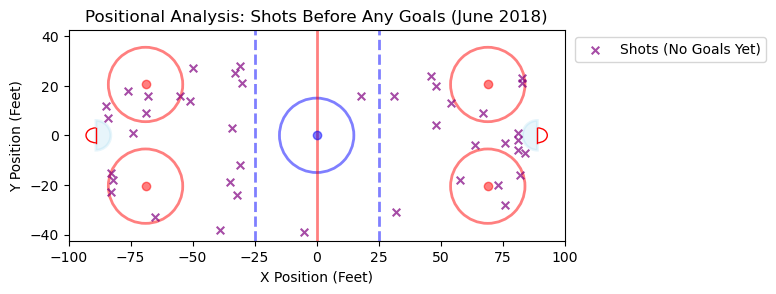

In [206]:
# Filter shots when goals_home == 0 and goals_away == 0 during June 2018
shots_no_goals_june_2018 = game_plays[
    (game_plays['event'] == 'Shot') &
    (game_plays['goals_home'] == 0) & 
    (game_plays['goals_away'] == 0) &
    (game_plays['dateTime'].dt.year == 2018) & 
    (game_plays['dateTime'].dt.month == 6)
]

# Set up the plot
ax = plt.gca()

# Draw the rink at current axes using the custom function
draw_rink(ax)

# Scatter plot for shots when no goals have been scored
ax.scatter(shots_no_goals_june_2018['x'], 
           shots_no_goals_june_2018['y'], 
           color='purple', marker='x', s=30, label='Shots (No Goals Yet)', alpha=0.7)

# Labels and legend
plt.title("Positional Analysis: Shots Before Any Goals (June 2018)")
plt.xlabel("X Position (Feet)")
plt.ylabel("Y Position (Feet)")
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.42, 1))
plt.show()


In this positional analysis, we look at shots before a goal has been scored during the month of June 2018. Only the best teams play in June, since this is when the final rounds of the playoffs happen. There is definitely a wide variety of shooting positions here, but we can see a lot of shot volume coming from the blue line where the majority of slap shots are taken.

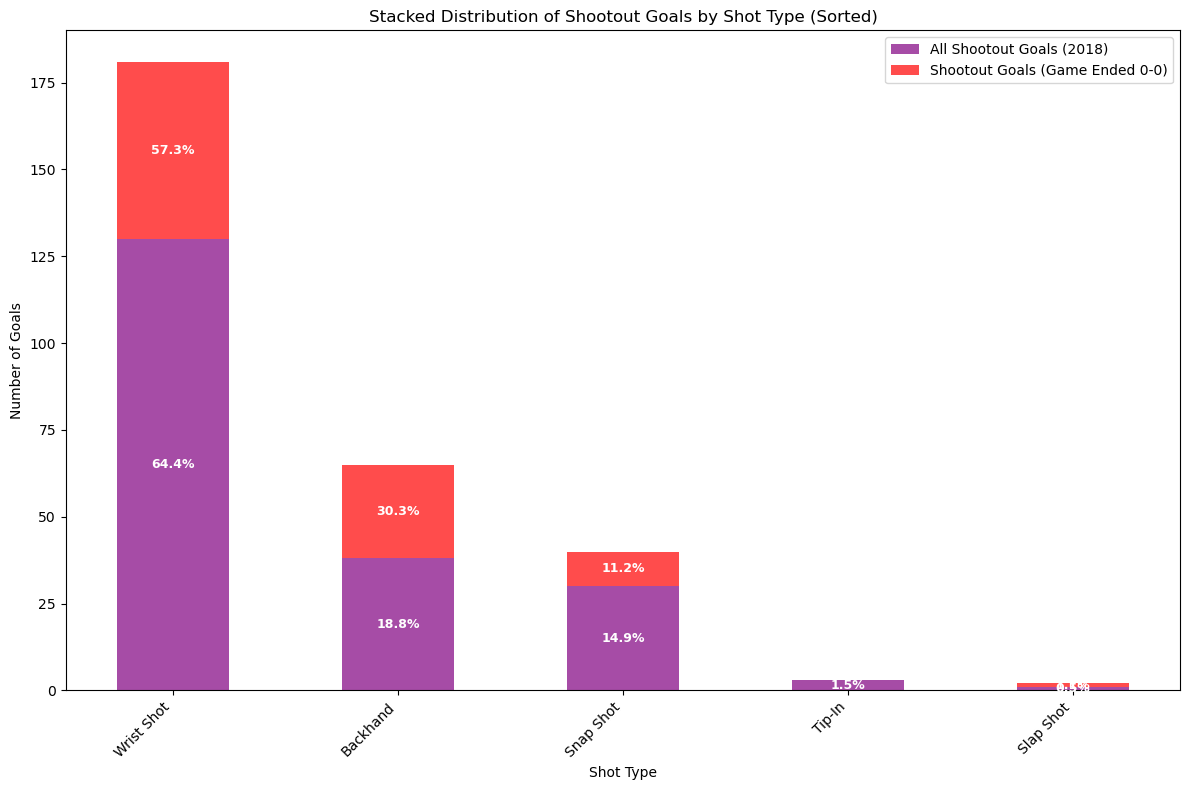

In [207]:
# Filter for shootout goals when the game ended 0-0
shootout_goals0 = game_plays[
    (game_plays['event'] == 'Goal') &
    (game_plays['goals_home'] == 0) &
    (game_plays['goals_away'] == 0) &
    (game_plays['period'] == 5)
].copy()  

# Filter for all shootout goals
shootout_goals = game_plays[
    (game_plays['event'] == 'Goal') &
    (game_plays['period'] == 5) &
    (game_plays['dateTime'].dt.year == 2018)
].copy()  

# Ensure secondaryType column is cleaned (convert to string and drop NaNs) using .loc
shootout_goals.loc[:, 'secondaryType'] = shootout_goals['secondaryType'].astype(str).fillna('')
shootout_goals0.loc[:, 'secondaryType'] = shootout_goals0['secondaryType'].astype(str).fillna('')

# Get unique shot types across both datasets
goal_types = sorted(set(shootout_goals['secondaryType'].dropna()).union(set(shootout_goals0['secondaryType'].dropna())))

# Count occurrences by shot type
shootout_goal_counts = [shootout_goals['secondaryType'].value_counts().get(goal_type, 0) for goal_type in goal_types]
shootout_goal0_counts = [shootout_goals0['secondaryType'].value_counts().get(goal_type, 0) for goal_type in goal_types]

# Calculate percentages
total_shootout_goals = sum(shootout_goal_counts)
total_shootout0_goals = sum(shootout_goal0_counts)
shootout_goal_percentages = [(count / total_shootout_goals * 100) if total_shootout_goals > 0 else 0 for count in shootout_goal_counts]
shootout_goal0_percentages = [(count / total_shootout0_goals * 100) if total_shootout0_goals > 0 else 0 for count in shootout_goal0_counts]

# Sort by total shootout goal counts in descending order
sorted_indices = np.argsort(shootout_goal_counts)[::-1]

goal_types_sorted = [goal_types[i] for i in sorted_indices]
shootout_goal_counts_sorted = [shootout_goal_counts[i] for i in sorted_indices]
shootout_goal0_counts_sorted = [shootout_goal0_counts[i] for i in sorted_indices]
shootout_goal_percentages_sorted = [shootout_goal_percentages[i] for i in sorted_indices]
shootout_goal0_percentages_sorted = [shootout_goal0_percentages[i] for i in sorted_indices]

# Create bar positions
x = np.arange(len(goal_types_sorted))
bar_width = 0.5  

# Set up the figure
plt.figure(figsize=(12, 8))

# Plot bars for both shootout goals (stacked)
bars1 = plt.bar(x, shootout_goal_counts_sorted, bar_width, color='purple', alpha=0.7, label='All Shootout Goals (2018)')
bars2 = plt.bar(x, shootout_goal0_counts_sorted, bar_width, color='red', alpha=0.7, label='Shootout Goals (Game Ended 0-0)', bottom=shootout_goal_counts_sorted)

# Add percentage annotations
for i in range(len(goal_types_sorted)):
    if shootout_goal_counts_sorted[i] > 0:
        plt.text(x[i], shootout_goal_counts_sorted[i] / 2, f"{shootout_goal_percentages_sorted[i]:.1f}%", 
                 ha='center', va='center', fontsize=9, color='white', fontweight='bold')
    if shootout_goal0_counts_sorted[i] > 0:
        plt.text(x[i], shootout_goal_counts_sorted[i] + (shootout_goal0_counts_sorted[i] / 2), f"{shootout_goal0_percentages_sorted[i]:.1f}%", 
                 ha='center', va='center', fontsize=9, color='white', fontweight='bold')

# Labels and title
plt.xlabel('Shot Type')
plt.ylabel('Number of Goals')
plt.title('Stacked Distribution of Shootout Goals by Shot Type (Sorted)')
plt.xticks(x, goal_types_sorted, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()





The final game situation we will look at is the shootout. During the regular season when a game ends in a tie and 5 minutes of 3 on 3 doesn't result in a goal, teams get a chance to send their best players in one on one against the goaltender. Using a stacked bar plot we contrast games where goals have been scored but ended tied with games that ended 0-0 where the goalies were really preforming well. Not surprisingly, wrist shots account for the majority of successful shootout goals in both situations. This is because many good players will elect to skate in, pick their spot and try and hit it with a wrist shot. Snap shots are also fairly common in both situations, as they come off the stick fast and can surprise a goalie. The largest disparity between these two situations is the backhand shot where 30% of the shootout goals in games that ended 0-0 occured as opposed tp 18.8%. In a shootout, backhand shots are generally preceded with some tricky stickhandling to get the goalie moving. It makes sense that in games where the goalies were perfect, it takes some trickery to finally get the puck in the net.

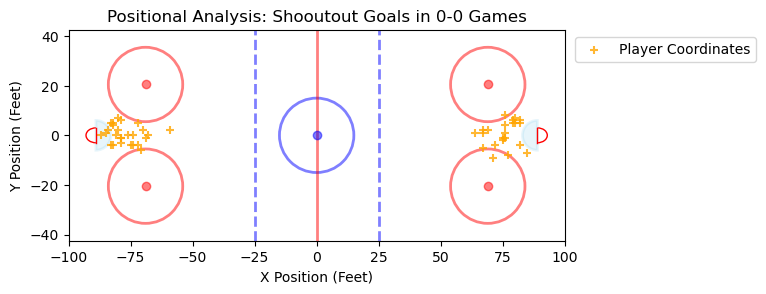

In [208]:
# Filter for shootout goals when no goals have been scored yet
goals_no_goals_against = game_plays[
    (game_plays['event'] == 'Goal') & 
    (game_plays['goals_home'] == 0) & 
    (game_plays['goals_away'] == 0)
]

# Set up the plot
ax = plt.gca()

# Draw the rink at current axes using the custom function
draw_rink(ax)

# Scatter plot for goals when no goals have been scored
ax.scatter(goals_no_goals_against['x'], 
           goals_no_goals_against['y'], 
           color='orange', marker='+', s=40, label='Player Coordinates', alpha=0.8)

# Labels and legend
plt.title("Positional Analysis: Shooutout Goals in 0-0 Games")
plt.xlabel("X Position (Feet)")
plt.ylabel("Y Position (Feet)")
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()


Finally, we visualize where players typically shoot from in shootouts. Specifically in games that ended 0-0. It comes to no surprise that when a player has the option of shooting from wherever they choose, it is going to be right in front of the net and generally as close as possible.